In [1]:
import os
import sys
import pandas as pd
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic1"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")
from codebase import (
    read_all_punt_to_punt, 
    make_detour_matrix, 
    number_of_residents_in_detour,
    municipality_name_column
)
%load_ext autoreload
%autoreload 2

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


This function calculates the number of people caught up with a detour greater than a given number, this is used to rank places according to the number of people who's detour could potentially be reduced

In [2]:
detour_factor = 2
within_mins = 30

punt = "trein" # ibis, hbo_wo, mbo, basis, highschool, bus, trein
mode = "fiets" # fiets, ebike
location = "Train - NS" # Elementary Schools, High Schools, Universities, Train - NS, Train - Local


df = number_of_residents_in_detour(detour_factor, punt, mode, within_mins)
grouped = df.groupby(['gm_naam']).sum('a_inw').sort_values(by='a_inw', ascending=False)
grouped.head(10)

Loaded file from CSV


,train_id,reistijd_min,reisafstand_m,afstand_hemelsbreed_m,omrijdfactor,a_inw
gm_naam,,,,,,
Nijmegen,840,8.0,2436.0,1028,4.72,22620
Stichtse Vecht,4293,92.0,25103.0,10470,30.19,12575
Zaanstad,933,6.0,1878.0,828,4.66,10990
Hilversum,704,16.0,3018.0,1172,5.13,8240
Venlo,2600,25.0,7248.0,3078,12.26,8170
Utrecht,1020,6.0,1165.0,464,4.88,7135
Voorst,497,2.0,665.0,297,2.24,5380
Eindhoven,273,3.0,1044.0,463,2.25,5170
Haarlem,981,18.0,4391.0,1936,8.97,5070


### Detour distribution matrix

The following shows the distirbution of mean detour factors for each destination type 

In [3]:
re_run_creating_matrix = False

if re_run_creating_matrix:
    punten = ['basis', 'bus', 'hbo_wo', 'highschool', 'ibis', 'mbo', 'trein']
    modes = ['fiets', 'ebike']

    matrix_data = read_all_punt_to_punt(punten, modes)

In [4]:
if re_run_creating_matrix:
    make_detour_matrix(matrix_data, savename="graphics/detour_matrix.png")
else:
    # Display the existing image if it exists 
    if os.path.exists("graphics/detour_matrix.png"):
        from PIL import Image
        img = Image.open("graphics/detour_matrix.png")
        img.show()
    else:
        print("Detour matrix image does not exist. Please run the detour matrix creation script.")

### Population weighted detour

The following is a calcutation of the population weighted detour factor, also plotted as a choropleth

In [5]:
from pathlib import Path
from codebase.buurt_calculations import calculate_population_weighted_detour

Loaded existing CSV from data\detour_result.csv
Top 10 municipalities by population-weighted detour factor:
          gm_naam  pop_weighted_detour  aantal_inwoners
244     Rozendaal             2.899829           1750.0
275     Tubbergen             2.492898          21410.0
225  Peel En Maas             2.390024          45280.0
257         Soest             2.096146          47455.0
3        Aalsmeer             1.939806          33065.0
276    Twenterand             1.928385          33875.0
46        Borsele             1.923137          22700.0
245       Rucphen             1.899814          23645.0
270         Texel             1.860479          13975.0
173     Maasdriel             1.859629          26015.0


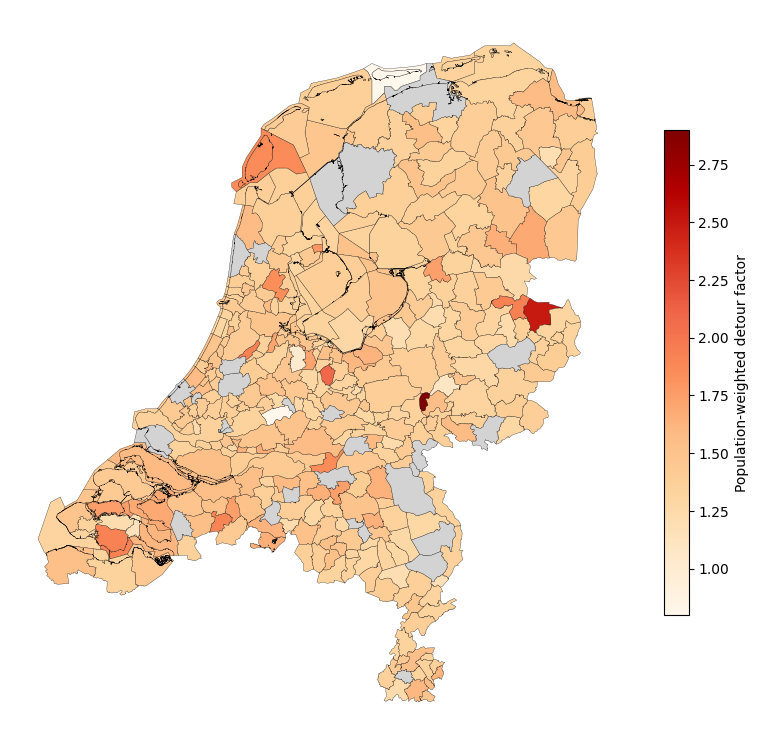

In [6]:
pop_weighted_df = calculate_population_weighted_detour(
    category="basis",
    modes=("fiets",),
    gpkg=Path("data\WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg"),
    out_csv=Path("data/detour_result.csv"),
    top_n=10,
    overwrite=False
)

## Calculate for popluation > 80_000

Loading punt to punt data: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Loaded file from CSV
CSV saved to data\detour_trein_fiets.csv
Top 10 municipalities by population-weighted detour factor:
            gm_naam  pop_weighted_detour  aantal_inwoners
228       Purmerend             1.847477          93980.0
135       Hilversum             1.720279          93315.0
136  Hoeksche Waard             1.553380          89745.0
71    Dijk En Waard             1.553104          88860.0
48            Breda             1.525098         186450.0
180     Meierijstad             1.505662          83735.0
17        Amsterdam             1.487531         917875.0
127         Helmond             1.468664          94890.0
282         Utrecht             1.455240         367715.0
219             Oss             1.453791          94450.0


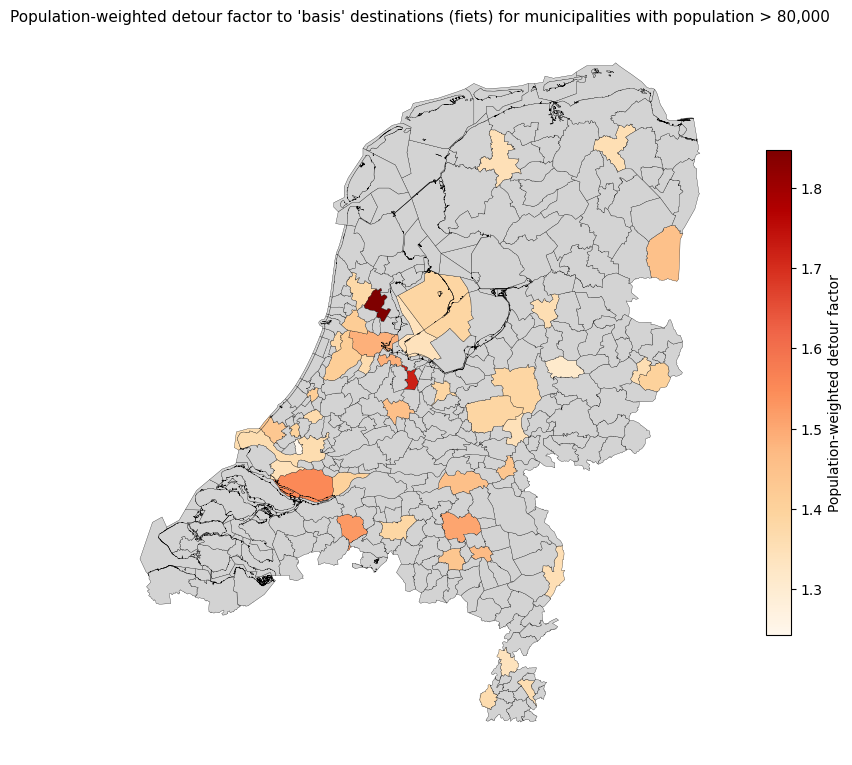

In [7]:
pop_weighted_df_min = calculate_population_weighted_detour(
    category="basis",
    modes=("fiets",),
    gpkg=Path("data\WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg"),
    out_csv=Path("data/detour_trein_fiets.csv"),
    population_threshold=80_000,
    overwrite=True,
    top_n=10
)

 ## Zoom in on municipalities with highest detour factor

Loading punt to punt data: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Loaded file from CSV


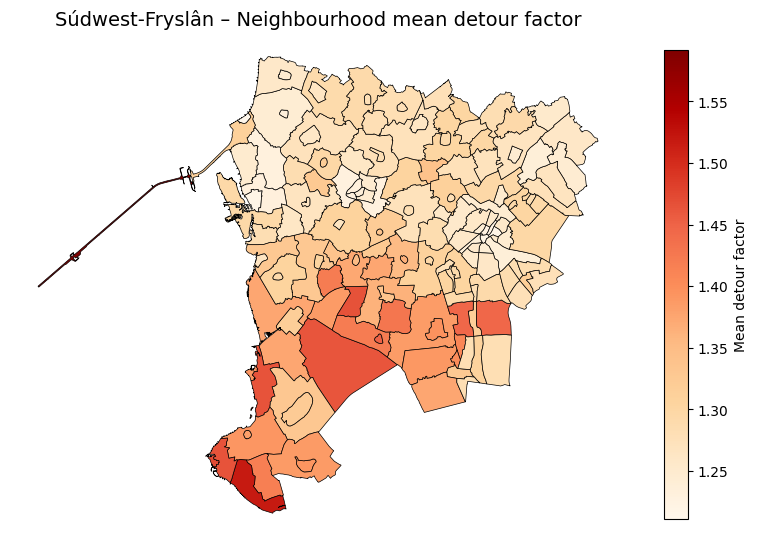

In [18]:

from codebase.buurt_calculations import read_all_punt_to_punt
from codebase.data_loading.load_demographics import load_demograhics
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


# Filter to the buurt/wijk
gdf_neigh = gpd.read_file("data/WijkBuurtkaart_2023_v2/wijkenbuurten_2023_v2.gpkg", layer="buurten")  # or "buurt" or "wijk"
# Choose categories and modes
categories = ["basis"]  # or others if needed
modes = ["fiets"]       # or add "ebike", etc.

# Load and concatenate all punt -> buurt matrices
matrices = read_all_punt_to_punt(categories, modes)
trips = pd.concat(matrices.values(), ignore_index=True)

# Load demo table
demo = load_demograhics()
TARGET_MUN = "Súdwest-Fryslân"  #muncipality
buurtcodes_terneuzen = gdf_neigh[gdf_neigh["gemeentenaam"].str.title() == TARGET_MUN]["buurtcode"].unique()
trips_terneuzen = trips[trips["bu_code"].isin(buurtcodes_terneuzen)].copy()
demo_terneuzen = demo[demo["gwb_code"].isin(buurtcodes_terneuzen)].copy()

# Compute detour for these buurten
neigh_detour = (
    trips_terneuzen.merge(
        demo_terneuzen[["gwb_code", "a_inw"]],
        left_on="bu_code", right_on="gwb_code",
        how="left")
    .groupby("gwb_code", as_index=False)
    .agg(mean_detour=("omrijdfactor", "mean"),
         population=("a_inw", "first"))
)

# Rename and merge as before
neigh_detour_renamed = neigh_detour.rename(columns={'gwb_code': 'buurtcode'})
gdf_mun = gdf_neigh[gdf_neigh["gemeentenaam"].str.title() == TARGET_MUN].copy()
gdf_mun = gdf_mun.merge(neigh_detour_renamed, on="buurtcode", how="left")

# Plot
fig, ax = plt.subplots(figsize=(8, 7))
gdf_mun.plot(
    column="mean_detour",
    cmap="OrRd",
    legend=True,
    legend_kwds={"label": "Mean detour factor", "shrink": 0.7},
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)
ax.set_title(f"{TARGET_MUN} – Neighbourhood mean detour factor", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.savefig(f"graphics/detour_map_{TARGET_MUN}.png", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
# ------------------------------------------------------------------
# Build all prerequisite variables used later: trips, demo, det, gdf
# ------------------------------------------------------------------
from pathlib import Path
import pandas as pd
import geopandas as gpd
from codebase.buurt_calculations import read_all_punt_to_punt
from codebase.data_loading.load_demographics import load_demograhics
from codebase.buurt_calculations import weighted_detour_by_municipality, load_municipality_geometry


# a. parameters
CATEGORY = "trein"
MODES    = ("fiets",)
GPKG     = Path("data/WijkBuurtkaart_2023_v2/wijkenbuurten_2023_v2.gpkg")

# b. trips
matrices = read_all_punt_to_punt([CATEGORY], list(MODES))
trips    = pd.concat(matrices.values(), ignore_index=True)

# c. demo
demo = load_demograhics()

# d. detour per gemeente
det = weighted_detour_by_municipality(trips, demo)

# e. geometry + merge
gdf = load_municipality_geometry(GPKG).merge(det, on=municipality_name_column, how="left")

print("Ready: trips, demo, det, gdf")
gdf_neigh = gpd.read_file(GPKG, layer="buurten")  # or "buurt" or "wijk"
gdf_neigh["gwb_code"] = gdf_neigh["buurtcode"]  # Ensure gwb_code is available for merging
# inspect columns:
print(gdf_neigh.columns)

# We'll assume there is a 'gwb_code' and 'gm_naam' column in gdf_neigh

TARGET_MUN = "Terneuzen"  # or any gm_naam you want

# Filter to only neighbourhoods in the selected municipality
gdf_mun = gdf_neigh[gdf_neigh["gemeentenaam"].str.title() == TARGET_MUN].copy()

# Merge with detour factors
gdf_mun = gdf_mun.merge(neigh_detour, on="gwb_code", how="left")


Loading punt to punt data: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


Loaded file from CSV
Ready: trips, demo, det, gdf
Index(['buurtcode', 'buurtnaam', 'wijkcode', 'gemeentecode', 'gemeentenaam',
       'indelingswijziging_wijken_en_buurten', 'water',
       'meest_voorkomende_postcode', 'dekkingspercentage',
       'omgevingsadressendichtheid',
       ...
       'afstand_tot_semiopenbaar_groen_totaal', 'afstand_tot_sportterrein',
       'afstand_tot_volkstuin', 'afstand_tot_verblijfsrecreatief_terrein',
       'afstand_tot_recreatief_binnenwater', 'afstand_tot_begraafplaats',
       'jrstatcode', 'jaar', 'geometry', 'gwb_code'],
      dtype='object', length=225)


## What share of these residents already lives within 30 min bike time as-the-crow-flies but exceeds 30
min on the actual network? (To key destinations, like trein, basis, mbo etc)

In [25]:
BIKE_SPEED = 21  # km/h
KMH_TO_M_PER_MIN = 1000 / 60 * BIKE_SPEED  # not needed, see below

# Crow-flies time in minutes (distance in meters → km → min)
trips["time_crow"] = (trips["afstand_hemelsbreed_m"] / 1000) / BIKE_SPEED * 60

# Network time is already present!
trips["time_net"] = trips["reistijd_min"]


In [26]:
# 2. aggregate to neighbourhood level (mean time per origin buurt)
time_per_buurt = (
    trips.groupby("bu_code", as_index=False)
         .agg(time_crow=("time_crow", "mean"),
              time_net =("time_net",  "mean"))
         .rename(columns={"bu_code": "buurtcode"})
)

# 3. add population
time_pop = time_per_buurt.merge(
    demo.rename(columns={"gwb_code": "buurtcode"})[["buurtcode", "a_inw"]],
    on="buurtcode", how="left"
)

# 4. (optional) add gemeente label for filtering
time_pop = time_pop.merge(
    gdf_neigh[["buurtcode", "gemeentenaam"]],
    on="buurtcode", how="left"
)


## Check per muncipality

In [27]:
TARGET_MUN = "Súdwest-Fryslân"

df_mun = time_pop[time_pop["gemeentenaam"].str.title() == TARGET_MUN]

within_30_crow = df_mun[df_mun["time_crow"] <= 30]
detour_residents = within_30_crow[within_30_crow["time_net"] > 30]

share = detour_residents["a_inw"].sum() / within_30_crow["a_inw"].sum()
print(f"{share:.1%} of residents in {TARGET_MUN} live ≤30min crow-flies but >30min on the network.")


nan% of residents in Súdwest-Fryslân live ≤30min crow-flies but >30min on the network.


C:\Users\toell\AppData\Local\Temp\ipykernel_26764\60364296.py:8: RuntimeWarning: invalid value encountered in scalar divide
  share = detour_residents["a_inw"].sum() / within_30_crow["a_inw"].sum()


## Check for whole netherlands

Top 10 municipalities with highest share of residents within 30 min crow-flies but >30 min on the network:
1. Beek: 100.0% (4,500 / 4,500 residents)
2. Beekdaelen: 100.0% (18,855 / 18,855 residents)
3. Emmen: 100.0% (405 / 405 residents)
4. Heerlen: 100.0% (20,240 / 20,240 residents)
5. Veere: 100.0% (4,885 / 4,885 residents)
6. Middelburg: 100.0% (40,175 / 40,175 residents)
7. Reimerswaal: 100.0% (5,545 / 5,545 residents)
8. Valkenburg aan de Geul: 100.0% (3,840 / 3,840 residents)
9. Vlissingen: 100.0% (30,115 / 30,115 residents)
10. Venlo: 100.0% (13,520 / 13,520 residents)


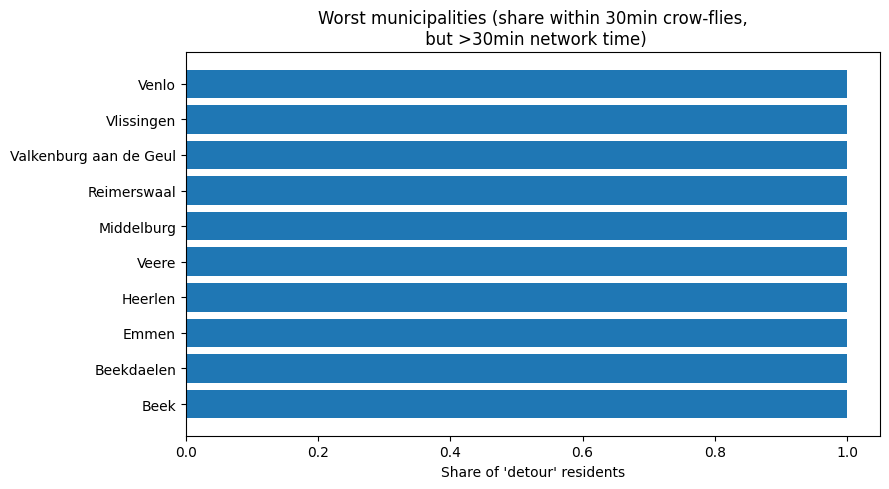

In [29]:
# Only keep buurten with valid data
valid = time_pop.dropna(subset=["gemeentenaam", "time_crow", "time_net", "a_inw"]).copy()

# Only buurten within 30 min crow-flies
within_30 = valid[valid["time_crow"] <= 30].copy()

# For those, which buurten exceed 30 min on the network?
within_30["detour_flag"] = within_30["time_net"] > 30

# Group per municipality
result = (
    within_30.groupby("gemeentenaam")
    .agg(
        pop_crow=("a_inw", "sum"),
        pop_detour=("detour_flag", lambda x: within_30.loc[x.index, "a_inw"][x].sum())
    )
    .assign(share=lambda d: d["pop_detour"] / d["pop_crow"])
    .dropna(subset=["share"])
    .query("pop_crow > 0")
    .sort_values("share", ascending=False)
)

# Print top 10 "worst" municipalities
top10 = result.head(10).reset_index()
print("Top 10 municipalities with highest share of residents within 30 min crow-flies but >30 min on the network:")
for i, row in top10.iterrows():
    print(f"{i+1}. {row['gemeentenaam']}: {row['share']:.1%} ({int(row['pop_detour']):,} / {int(row['pop_crow']):,} residents)")

# (Optional) plot bar chart
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(top10["gemeentenaam"], top10["share"])
ax.set_xlabel("Share of 'detour' residents")
ax.set_title("Worst municipalities (share within 30min crow-flies,\n but >30min network time)")
plt.tight_layout()
plt.show()


In [30]:
print("Total buurten in time_pop:", len(time_pop))
print("Buurten with time_crow <= 30:", (time_pop["time_crow"] <= 30).sum())
print("Buurten with time_crow <= 30 AND time_net > 30:", ((time_pop["time_crow"] <= 30) & (time_pop["time_net"] > 30)).sum())


Total buurten in time_pop: 14360
Buurten with time_crow <= 30: 192
Buurten with time_crow <= 30 AND time_net > 30: 183


In [31]:
print(time_pop[["gemeentenaam", "time_crow", "time_net", "a_inw"]].sample(10))



                 gemeentenaam  time_crow    time_net   a_inw
1784                Oldenzaal  38.788214   52.812500    95.0
746                Opsterland  62.489610   92.454545   525.0
6657   Krimpen aan den IJssel  48.867356   79.063830  4035.0
9068                  Tilburg  44.715306   60.214286  1365.0
4835                   Diemen  46.286846   66.679245  1355.0
14351          Voorne aan Zee  63.452180  115.263158  2580.0
2902                 Nijmegen  43.961382   64.419355  6890.0
13856       Noardeast-Fryslân  50.073506   69.727273  5490.0
11738                Westland  47.921645   67.666667  2080.0
6481            's-Gravenhage  44.908824   61.117647  7305.0


In [32]:
print("Any NaN in time_crow?", time_pop["time_crow"].isna().sum())
print("Any NaN in time_net?", time_pop["time_net"].isna().sum())


Any NaN in time_crow? 0
Any NaN in time_net? 0


In [33]:
# Assume 'trips' has one row per OD pair: origin = bu_code, destination = <punt_type>
# and columns 'afstand_hemelsbreed_m', 'reistijd_min' etc.

BIKE_SPEED = 21  # km/h
trips["time_crow"] = (trips["afstand_hemelsbreed_m"] / 1000) / BIKE_SPEED * 60
trips["time_net"] = trips["reistijd_min"]

# For each buurt, get the MINIMUM time to any key destination (e.g. any "trein" station)
# Suppose you filter trips for one category first:
# trips_filtered = trips[trips["punt_type"] == "trein"]   # adjust as needed

# Now group by origin buurt:
time_min_per_buurt = (
    trips.groupby("bu_code", as_index=False)
         .agg(time_crow_min=("time_crow", "min"),
              time_net_min =("time_net",  "min"))
         .rename(columns={"bu_code": "buurtcode"})
)

# Add population and gemeente label:
time_min_pop = time_min_per_buurt.merge(
    demo.rename(columns={"gwb_code": "buurtcode"})[["buurtcode", "a_inw"]],
    on="buurtcode", how="left"
).merge(
    gdf_neigh[["buurtcode", "gemeentenaam"]],
    on="buurtcode", how="left"
)

# Now use the earlier logic:
within_30 = time_min_pop[time_min_pop["time_crow_min"] <= 30].copy()
within_30["detour_flag"] = within_30["time_net_min"] > 30

result = (
    within_30.groupby("gemeentenaam")
    .agg(
        pop_crow=("a_inw", "sum"),
        pop_detour=("detour_flag", lambda x: within_30.loc[x.index, "a_inw"][x].sum())
    )
    .assign(share=lambda d: d["pop_detour"] / d["pop_crow"])
    .dropna(subset=["share"])
    .query("pop_crow > 0")
    .sort_values("share", ascending=False)
)

top10 = result.head(10).reset_index()
print(top10)


        gemeentenaam  pop_crow  pop_detour  share
0  West Maas en Waal   20065.0     20065.0    1.0
1           Waalwijk    1250.0      1250.0    1.0
2           Bergeijk     220.0       220.0    1.0
3              Vaals    9640.0      9640.0    1.0
4           Uithoorn   31440.0     31440.0    1.0
5              Texel     780.0       780.0    1.0
6        Stadskanaal    3170.0      3170.0    1.0
7              Sluis    7595.0      7595.0    1.0
8   Ooststellingwerf     295.0       295.0    1.0
9    Noordoostpolder    1245.0      1245.0    1.0


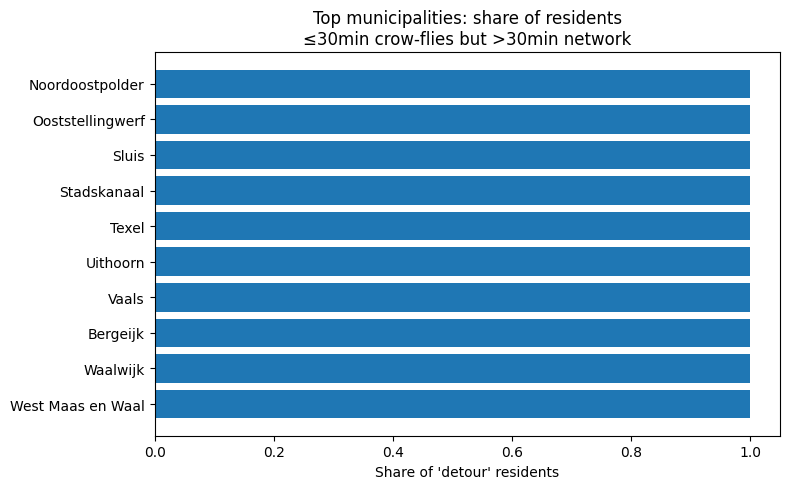

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top10["gemeentenaam"], top10["share"])
ax.set_xlabel("Share of 'detour' residents")
ax.set_title("Top municipalities: share of residents\n≤30min crow-flies but >30min network")
plt.tight_layout()
plt.show()
